# Практична робота №2: Логістична регресія з нуля

## Завдання
- Реалізувати логістичну регресію з нуля для класифікації результатів медичних тестів.
- Реалізувати оптимізацію: SGD і mini-batch.
- Дослідити вплив регуляризації (L1/L2).
- Оцінити якість моделі (confusion matrix, Accuracy, Precision, Recall, F1).
- Побудувати криві навчання.
- Зробити висновки.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

## 1. Завантаження та підготовка даних

In [7]:
df = pd.read_csv("healthcare_dataset.csv")

In [8]:
# Перевіримо структуру даних та створимо цільову змінну
print("Колонки:", df.columns.tolist())
print("Форма:", df.shape)
print("Унікальні значення Test Results:", df['Test Results'].unique())

# Створимо бінарну цільову змінну: 1 для 'Normal', 0 для інших
df['Test_Result_Normal'] = (df['Test Results'] == 'Normal').astype(int)
print("Розподіл цільової змінної:", df['Test_Result_Normal'].value_counts())
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()


Колонки: ['Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition', 'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider', 'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date', 'Medication', 'Test Results']
Форма: (55500, 15)
Унікальні значення Test Results: ['Normal' 'Inconclusive' 'Abnormal']
Розподіл цільової змінної: Test_Result_Normal
0    36983
1    18517
Name: count, dtype: int64


In [9]:
# Балансування даних
normal_data = df[df['Test_Result_Normal'] == 1]
abnormal_data = df[df['Test_Result_Normal'] == 0].sample(n=len(normal_data), random_state=42)
df = pd.concat([normal_data, abnormal_data]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Після балансування: {df['Test_Result_Normal'].value_counts().to_dict()}")

Після балансування: {0: 18517, 1: 18517}


### Аналіз кореляцій між ознаками

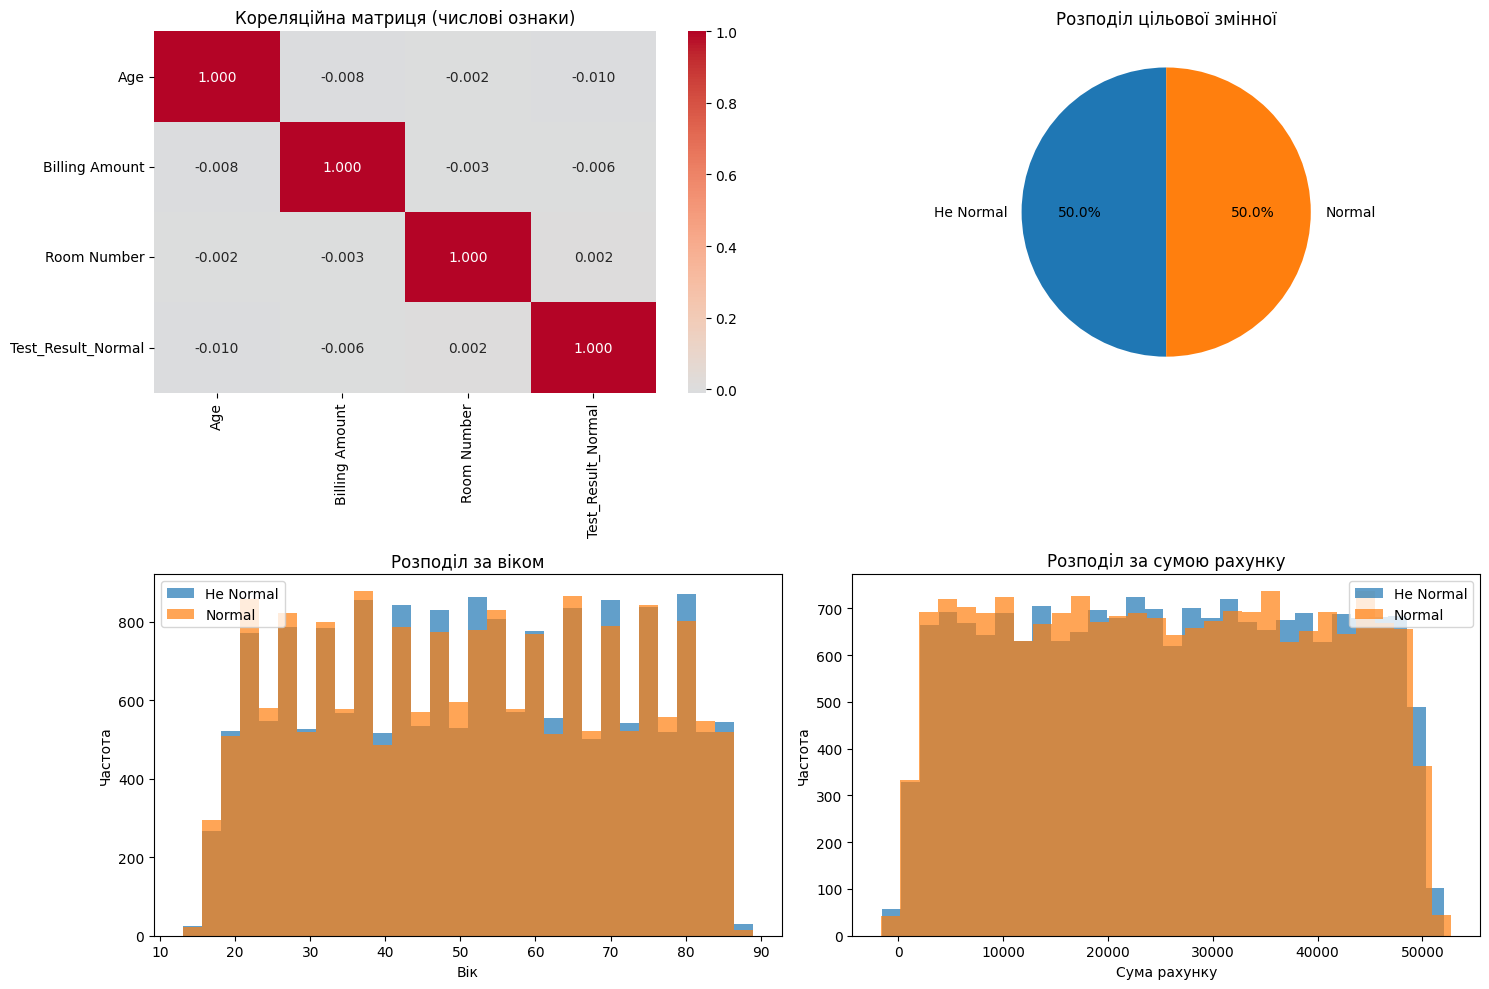

Кореляція з цільовою змінною:
Age: 0.0102
Billing Amount: 0.0058
Room Number: 0.0022


In [10]:
# Аналіз кореляцій між ознаками
plt.figure(figsize=(15, 10))

# Кореляційна матриця для числових ознак
numeric_corr = df[numeric_features + ['Test_Result_Normal']].corr()

plt.subplot(2, 2, 1)
sns.heatmap(numeric_corr, annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title('Кореляційна матриця (числові ознаки)')

# Розподіл цільової змінної
plt.subplot(2, 2, 2)
target_counts = df['Test_Result_Normal'].value_counts()
plt.pie(target_counts.values, labels=['Не Normal', 'Normal'], autopct='%1.1f%%', startangle=90)
plt.title('Розподіл цільової змінної')

# Розподіл за віком
plt.subplot(2, 2, 3)
plt.hist(df[df['Test_Result_Normal']==0]['Age'], alpha=0.7, label='Не Normal', bins=30)
plt.hist(df[df['Test_Result_Normal']==1]['Age'], alpha=0.7, label='Normal', bins=30)
plt.xlabel('Вік')
plt.ylabel('Частота')
plt.title('Розподіл за віком')
plt.legend()

# Розподіл за сумою рахунку
plt.subplot(2, 2, 4)
plt.hist(df[df['Test_Result_Normal']==0]['Billing Amount'], alpha=0.7, label='Не Normal', bins=30)
plt.hist(df[df['Test_Result_Normal']==1]['Billing Amount'], alpha=0.7, label='Normal', bins=30)
plt.xlabel('Сума рахунку')
plt.ylabel('Частота')
plt.title('Розподіл за сумою рахунку')
plt.legend()

plt.tight_layout()
plt.show()

print("Кореляція з цільовою змінною:")
correlations_with_target = numeric_corr['Test_Result_Normal'].abs().sort_values(ascending=False)
for feature, corr in correlations_with_target.items():
    if feature != 'Test_Result_Normal':
        print(f"{feature}: {corr:.4f}")

In [11]:
# Відберемо числові ознаки та категоріальні для one-hot encoding
numeric_features = ['Age', 'Billing Amount', 'Room Number']
categorical_features = ['Gender', 'Blood Type', 'Medical Condition', 'Admission Type', 'Medication']

X_numeric = df[numeric_features]
X_categorical = df[categorical_features]

# One-hot encoding для категоріальних ознак
X_categorical_enc = pd.get_dummies(X_categorical, drop_first=True)

# Об'єднуємо числові та закодовані категоріальні ознаки
X = pd.concat([X_numeric, X_categorical_enc], axis=1)
y = df['Test_Result_Normal'].values

# Стандартизація ознак
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Додаємо bias term (стовпець одиниць)
X_scaled = np.column_stack([np.ones(X_scaled.shape[0]), X_scaled])

# Розділяємо дані
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Розміри наборів: Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Кількість ознак (з bias): {X_train.shape[1]}")

Розміри наборів: Train: (22220, 23), Val: (7407, 23), Test: (7407, 23)
Кількість ознак (з bias): 23


## 2. Реалізація логістичної регресії з нуля

In [12]:
def sigmoid(z):
    """Сигмоїдна функція з захистом від overflow/underflow"""
    z = np.clip(z, -250, 250)
    return 1 / (1 + np.exp(-z))

def compute_loss(X, y, w, reg=None, alpha=0.01):
    """
    Обчислення функції втрат (Binary Cross-Entropy) з регуляризацією
    """
    m = len(y)
    z = X.dot(w)
    preds = sigmoid(z)
    
    # Додаємо невелике число для уникнення log(0)
    eps = 1e-15
    preds = np.clip(preds, eps, 1 - eps)
    
    # Binary Cross-Entropy Loss
    bce_loss = -np.mean(y * np.log(preds) + (1 - y) * np.log(1 - preds))
    
    # Додаємо регуляризацію (не регуляризуємо bias term w[0])
    regularization = 0
    if reg == "l2" or reg == "ridge":
        # L2 регуляризація (Ridge): сума квадратів ваг
        regularization = alpha * np.sum(w[1:] ** 2) / (2 * m)
    elif reg == "l1" or reg == "lasso":
        # L1 регуляризація (Lasso): сума абсолютних значень ваг
        regularization = alpha * np.sum(np.abs(w[1:])) / m
    
    return bce_loss + regularization

def compute_gradients(X, y, w, reg=None, alpha=0.01):
    """
    Обчислення градієнтів функції втрат з регуляризацією
    """
    m = len(y)
    z = X.dot(w)
    preds = sigmoid(z)
    
    # Основні градієнти від Binary Cross-Entropy
    grad = X.T.dot(preds - y) / m
    
    # Додаємо регуляризаційні градієнти (не регуляризуємо bias term w[0])
    if reg == "l2" or reg == "ridge":
        # Градієнт L2 регуляризації: 2 * alpha * w
        grad[1:] += alpha * w[1:] / m
    elif reg == "l1" or reg == "lasso":
        # Градієнт L1 регуляризації: alpha * sign(w)
        grad[1:] += alpha * np.sign(w[1:]) / m
    
    return grad

def predict_proba(X, w):
    """Обчислення ймовірностей класифікації"""
    return sigmoid(X.dot(w))

def predict(X, w, threshold=0.5):
    """Класифікація з заданим порогом"""
    probabilities = predict_proba(X, w)
    return (probabilities >= threshold).astype(int), probabilities

### Оптимізація: SGD і Mini-batch

In [13]:
def train_logistic(X_train, y_train, X_val, y_val, epochs=100, lr=0.01, batch_size=32, 
                  reg=None, alpha=0.01, mode='minibatch', early_stopping=True, patience=10):
    """
    Навчання логістичної регресії з підтримкою:
    """
    m, n = X_train.shape
    w = np.random.normal(0, 0.01, n)  # Невелика ініціалізація замість нулів
    train_losses = []
    val_losses = []
    
    # Early stopping параметри
    best_val_loss = float('inf')
    best_weights = None
    patience_counter = 0
    
    print(f"Початок навчання: {mode.upper()}")
    print(f"Регуляризація: {reg if reg else 'Без регуляризації'}, Alpha: {alpha}")
    print(f"Early stopping: {'Увімкнено' if early_stopping else 'Вимкнено'}, Patience: {patience}")
    print("-" * 60)
    
    for epoch in range(epochs):
        # Навчання
        if mode == 'sgd':
            indices = np.random.permutation(m)
            for i in indices:
                xi = X_train[i:i+1]  # Зберігаємо 2D форму
                yi = y_train[i:i+1]
                grad = compute_gradients(xi, yi, w, reg, alpha)
                w -= lr * grad
                
        elif mode == 'minibatch':
            indices = np.random.permutation(m)
            for i in range(0, m, batch_size):
                batch_indices = indices[i:i+batch_size]
                Xi = X_train[batch_indices]
                yi = y_train[batch_indices]
                grad = compute_gradients(Xi, yi, w, reg, alpha)
                w -= lr * grad
        
        # Обчислюємо loss після кожної епохи
        train_loss = compute_loss(X_train, y_train, w, reg, alpha)
        val_loss = compute_loss(X_val, y_val, w, reg, alpha)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Early stopping logic
        if early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_weights = w.copy()  # Зберігаємо кращі ваги
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                print(f"Early stopping на епосі {epoch+1}")
                print(f"Кращий val loss: {best_val_loss:.4f}")
                w = best_weights  # Повертаємо кращі ваги
                break
        
        # Виводимо прогрес кожні 25 епох
        if (epoch + 1) % 25 == 0:
            print(f"Epoch {epoch+1:3d}/{epochs}, Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Patience: {patience_counter}/{patience}")
    
    # Якщо early stopping не використовувався, але є кращі ваги
    if early_stopping and best_weights is not None:
        final_weights = best_weights
    else:
        final_weights = w
    
    print(f"Навчання завершено. Фінальний val loss: {val_losses[-1]:.4f}")
    print("=" * 60)
    
    return final_weights, train_losses, val_losses

## 3. Навчання і криві навчання

🚀 Початок експериментів з різними методами оптимізації

1️⃣ Навчання SGD (без регуляризації)
Початок навчання: SGD
Регуляризація: Без регуляризації, Alpha: 0
Early stopping: Увімкнено, Patience: 15
------------------------------------------------------------
Early stopping на епосі 16
Кращий val loss: 0.7011
Навчання завершено. Фінальний val loss: 0.7211

2️⃣ Навчання Mini-batch (без регуляризації)
Початок навчання: MINIBATCH
Регуляризація: Без регуляризації, Alpha: 0
Early stopping: Увімкнено, Patience: 15
------------------------------------------------------------
Early stopping на епосі 16
Кращий val loss: 0.6939
Навчання завершено. Фінальний val loss: 0.6950

3️⃣ Навчання Mini-batch + L1 (Lasso)
Початок навчання: MINIBATCH
Регуляризація: l1, Alpha: 0.01
Early stopping: Увімкнено, Patience: 15
------------------------------------------------------------
Early stopping на епосі 16
Кращий val loss: 0.6941
Навчання завершено. Фінальний val loss: 0.6945

4️⃣ Навчання Mini-batch + L2 (R

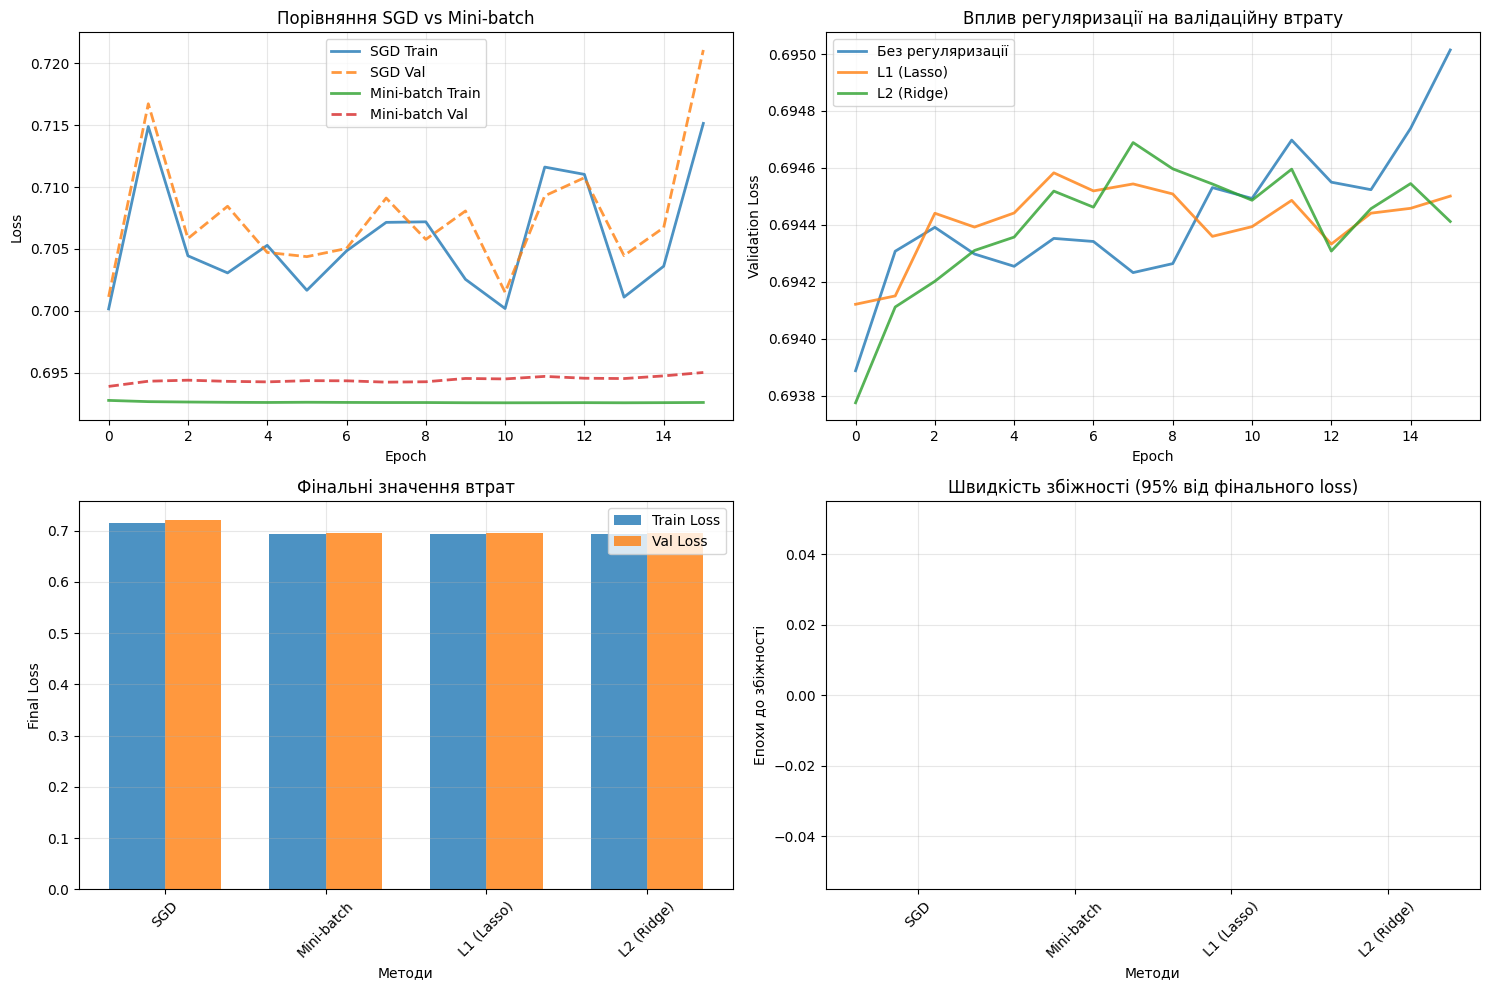


📊 Підсумок навчання:
SGD: Train 0.7152, Val 0.7211, Epoki: 16
Mini-batch: Train 0.6926, Val 0.6950, Epoki: 16
L1 (Lasso): Train 0.6926, Val 0.6945, Epoki: 16
L2 (Ridge): Train 0.6926, Val 0.6944, Epoki: 16


In [14]:
# Навчання з різними методами та візуалізація кривих навчання
print("🚀 Початок експериментів з різними методами оптимізації")
print("=" * 70)

# Параметри навчання
epochs = 150
learning_rate = 0.01
batch_size = 64

# Навчання SGD без регуляризації
print("\n1️⃣ Навчання SGD (без регуляризації)")
w_sgd, loss_sgd, val_sgd = train_logistic(
    X_train, y_train, X_val, y_val,
    epochs=epochs, lr=learning_rate, mode='sgd',
    reg=None, alpha=0, early_stopping=True, patience=15
)

# Навчання Mini-batch без регуляризації
print("\n2️⃣ Навчання Mini-batch (без регуляризації)")
w_mb, loss_mb, val_mb = train_logistic(
    X_train, y_train, X_val, y_val,
    epochs=epochs, lr=learning_rate, batch_size=batch_size, mode='minibatch',
    reg=None, alpha=0, early_stopping=True, patience=15
)

# Навчання Mini-batch з L1 регуляризацією
print("\n3️⃣ Навчання Mini-batch + L1 (Lasso)")
w_l1, loss_l1, val_l1 = train_logistic(
    X_train, y_train, X_val, y_val,
    epochs=epochs, lr=learning_rate, batch_size=batch_size, mode='minibatch',
    reg='l1', alpha=0.01, early_stopping=True, patience=15
)

# Навчання Mini-batch з L2 регуляризацією
print("\n4️⃣ Навчання Mini-batch + L2 (Ridge)")
w_l2, loss_l2, val_l2 = train_logistic(
    X_train, y_train, X_val, y_val,
    epochs=epochs, lr=learning_rate, batch_size=batch_size, mode='minibatch',
    reg='l2', alpha=0.01, early_stopping=True, patience=15
)

# Візуалізація кривих навчання
plt.figure(figsize=(15, 10))

# График 1: Порівняння SGD vs Mini-batch
plt.subplot(2, 2, 1)
plt.plot(loss_sgd, label='SGD Train', alpha=0.8, linewidth=2)
plt.plot(val_sgd, label='SGD Val', alpha=0.8, linewidth=2, linestyle='--')
plt.plot(loss_mb, label='Mini-batch Train', alpha=0.8, linewidth=2)
plt.plot(val_mb, label='Mini-batch Val', alpha=0.8, linewidth=2, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Порівняння SGD vs Mini-batch')
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: Вплив регуляризації
plt.subplot(2, 2, 2)
plt.plot(val_mb, label='Без регуляризації', alpha=0.8, linewidth=2)
plt.plot(val_l1, label='L1 (Lasso)', alpha=0.8, linewidth=2)
plt.plot(val_l2, label='L2 (Ridge)', alpha=0.8, linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Вплив регуляризації на валідаційну втрату')
plt.legend()
plt.grid(True, alpha=0.3)

# График 3: Train vs Val Loss для різних методів
plt.subplot(2, 2, 3)
methods = ['SGD', 'Mini-batch', 'L1 (Lasso)', 'L2 (Ridge)']
train_final = [loss_sgd[-1], loss_mb[-1], loss_l1[-1], loss_l2[-1]]
val_final = [val_sgd[-1], val_mb[-1], val_l1[-1], val_l2[-1]]

x = np.arange(len(methods))
width = 0.35

plt.bar(x - width/2, train_final, width, label='Train Loss', alpha=0.8)
plt.bar(x + width/2, val_final, width, label='Val Loss', alpha=0.8)
plt.xlabel('Методи')
plt.ylabel('Final Loss')
plt.title('Фінальні значення втрат')
plt.xticks(x, methods, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# График 4: Швидкість збіжності
plt.subplot(2, 2, 4)
# Знаходимо епоху досягнення 95% від фінального loss
def convergence_epoch(losses, threshold=0.95):
    final_loss = losses[-1]
    target = final_loss / threshold
    for i, loss in enumerate(losses):
        if loss <= target:
            return i
    return len(losses)

conv_epochs = [convergence_epoch(val_sgd), convergence_epoch(val_mb), 
               convergence_epoch(val_l1), convergence_epoch(val_l2)]

plt.bar(methods, conv_epochs, alpha=0.8, color=['skyblue', 'lightgreen', 'orange', 'lightcoral'])
plt.xlabel('Методи')
plt.ylabel('Епохи до збіжності')
plt.title('Швидкість збіжності (95% від фінального loss)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Підсумок навчання:")
print(f"SGD: Train {loss_sgd[-1]:.4f}, Val {val_sgd[-1]:.4f}, Epoki: {len(loss_sgd)}")
print(f"Mini-batch: Train {loss_mb[-1]:.4f}, Val {val_mb[-1]:.4f}, Epoki: {len(loss_mb)}")
print(f"L1 (Lasso): Train {loss_l1[-1]:.4f}, Val {val_l1[-1]:.4f}, Epoki: {len(loss_l1)}")
print(f"L2 (Ridge): Train {loss_l2[-1]:.4f}, Val {val_l2[-1]:.4f}, Epoki: {len(loss_l2)}")

## 4. Оцінка на тестових даних

📊 ОЦІНКА МОДЕЛЕЙ НА ТЕСТОВОМУ НАБОРІ

🔍 Аналіз моделі: SGD
----------------------------------------
📈 Статистика ймовірностей:
   Мін: 0.3159, Макс: 0.7077
   Середнє: 0.5007, Медіана: 0.4997
   Стандартне відхилення: 0.0597

🎯 Аналіз різних порогів (топ-5 за F1-score):
   1. Поріг: 0.10 → F1: 0.6678, Acc: 0.5013, Prec: 0.5013, Rec: 1.0000
   2. Поріг: 0.15 → F1: 0.6678, Acc: 0.5013, Prec: 0.5013, Rec: 1.0000
   3. Поріг: 0.20 → F1: 0.6678, Acc: 0.5013, Prec: 0.5013, Rec: 1.0000
   4. Поріг: 0.25 → F1: 0.6678, Acc: 0.5013, Prec: 0.5013, Rec: 1.0000
   5. Поріг: 0.30 → F1: 0.6678, Acc: 0.5013, Prec: 0.5013, Rec: 1.0000

🏆 КРАЩИЙ ПОРІГ: 0.10
   Accuracy:  0.5013
   Precision: 0.5013
   Recall:    1.0000
   F1-score:  0.6678

📋 Confusion Matrix:
   [[TN=   0, FP=3694]]
   [[FN=   0, TP=3713]]

🔍 Аналіз моделі: Mini-batch
----------------------------------------
📈 Статистика ймовірностей:
   Мін: 0.4622, Макс: 0.5392
   Середнє: 0.4962, Медіана: 0.4958
   Стандартне відхилення: 0.0113

🎯 А

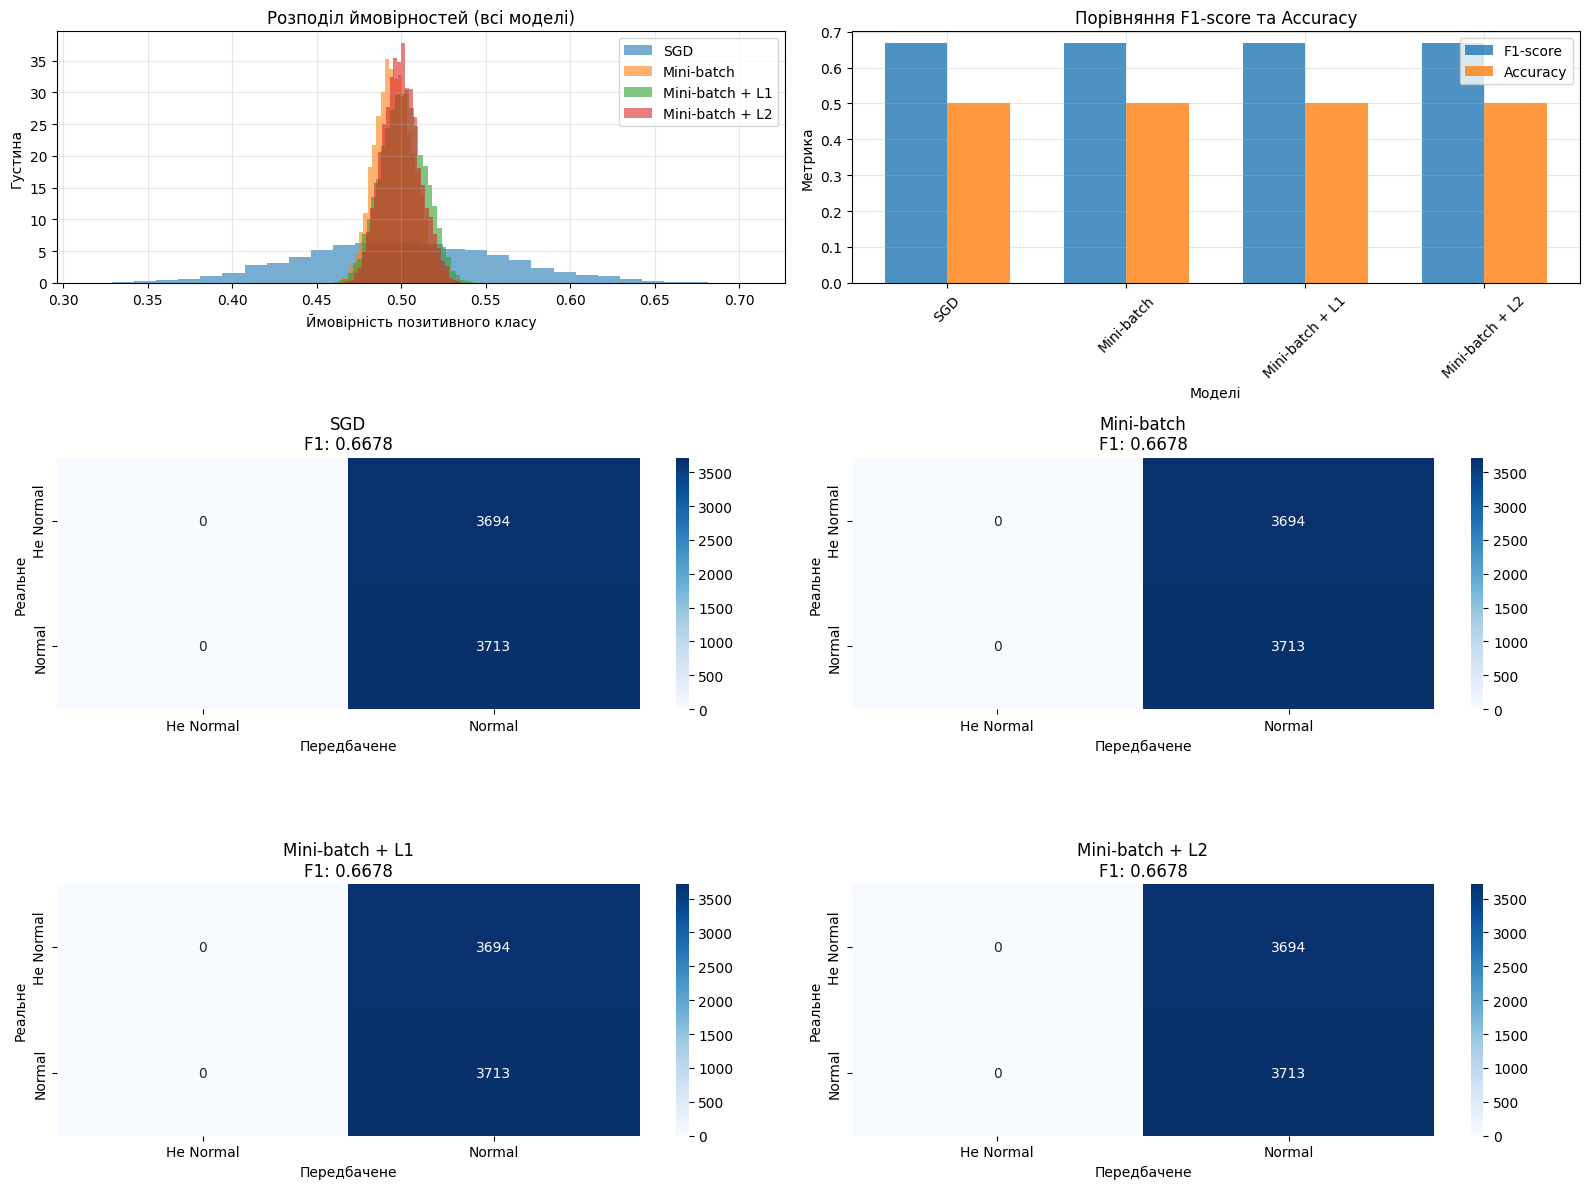


📊 ПІДСУМКОВА ТАБЛИЦЯ РЕЗУЛЬТАТІВ НА ТЕСТОВИХ ДАНИХ
Модель          Поріг  Accuracy  Precision  Recall  F1-score
------------------------------------------------------------------------------------------
SGD             0.10   0.5013    0.5013     1.0000  0.6678  
Mini-batch      0.10   0.5013    0.5013     1.0000  0.6678  
Mini-batch + L1 0.10   0.5013    0.5013     1.0000  0.6678  
Mini-batch + L2 0.10   0.5013    0.5013     1.0000  0.6678  

🏆 КРАЩA МОДЕЛЬ: SGD (F1-score: 0.6678)

🎯 ДЕТАЛЬНИЙ АНАЛІЗ КРАЩОЇ МОДЕЛІ (SGD):
--------------------------------------------------
True Negatives:     0 | False Positives: 3694
False Negatives:    0 | True Positives:  3713

Специфічність (Specificity): 0.0000
Чутливість (Sensitivity):    1.0000
Позитивна передбачувальна вартість: 0.5013
Негативна передбачувальна вартість: nan

💡 Інтерпретація результатів:
• Модель правильно класифікує 50.1% випадків
• З усіх позитивних передбачень 50.1% є правильними
• Модель знаходить 100.0% усіх справжніх пози

C:\Users\38093\AppData\Local\Temp\ipykernel_1864\2312307637.py:179: RuntimeWarning: invalid value encountered in scalar divide
  print(f"Негативна передбачувальна вартість: {tn/(tn+fn):.4f}")


In [15]:
# 🎯 Детальна оцінка моделей на тестових даних
print("📊 ОЦІНКА МОДЕЛЕЙ НА ТЕСТОВОМУ НАБОРІ")
print("=" * 60)

# Функція для детального аналізу моделі
def evaluate_model_detailed(X_test, y_test, weights, model_name):
    """Детальна оцінка моделі з оптимізацією порогу"""
    print(f"\n🔍 Аналіз моделі: {model_name}")
    print("-" * 40)
    
    # Отримуємо ймовірності
    y_prob = predict_proba(X_test, weights)
    
    # Статистика ймовірностей
    print(f"📈 Статистика ймовірностей:")
    print(f"   Мін: {y_prob.min():.4f}, Макс: {y_prob.max():.4f}")
    print(f"   Середнє: {y_prob.mean():.4f}, Медіана: {np.median(y_prob):.4f}")
    print(f"   Стандартне відхилення: {y_prob.std():.4f}")
    
    # Знаходимо оптимальний поріг
    best_f1 = 0
    best_threshold = 0.5
    best_metrics = None
    
    thresholds = np.linspace(0.1, 0.9, 17)
    threshold_results = []
    
    for thresh in thresholds:
        y_pred, _ = predict(X_test, weights, thresh)
        
        if y_pred.sum() > 0:  # Якщо є позитивні передбачення
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            
            threshold_results.append({
                'threshold': thresh,
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1': f1,
                'predictions': y_pred
            })
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = thresh
                best_metrics = {
                    'accuracy': acc,
                    'precision': prec,
                    'recall': rec,
                    'f1': f1,
                    'predictions': y_pred
                }
    
    # Виводимо результати для різних порогів
    print(f"\n🎯 Аналіз різних порогів (топ-5 за F1-score):")
    sorted_results = sorted(threshold_results, key=lambda x: x['f1'], reverse=True)[:5]
    
    for i, result in enumerate(sorted_results):
        print(f"   {i+1}. Поріг: {result['threshold']:.2f} → "
              f"F1: {result['f1']:.4f}, Acc: {result['accuracy']:.4f}, "
              f"Prec: {result['precision']:.4f}, Rec: {result['recall']:.4f}")
    
    print(f"\n🏆 КРАЩИЙ ПОРІГ: {best_threshold:.2f}")
    print(f"   Accuracy:  {best_metrics['accuracy']:.4f}")
    print(f"   Precision: {best_metrics['precision']:.4f}")
    print(f"   Recall:    {best_metrics['recall']:.4f}")
    print(f"   F1-score:  {best_metrics['f1']:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, best_metrics['predictions'])
    print(f"\n📋 Confusion Matrix:")
    print(f"   [[TN={cm[0,0]:4d}, FP={cm[0,1]:4d}]]")
    print(f"   [[FN={cm[1,0]:4d}, TP={cm[1,1]:4d}]]")
    
    return best_threshold, best_metrics, threshold_results

# Оцінюємо всі навчені моделі
models_to_evaluate = [
    (w_sgd, "SGD"),
    (w_mb, "Mini-batch"),
    (w_l1, "Mini-batch + L1"),
    (w_l2, "Mini-batch + L2")
]

evaluation_results = {}

for weights, name in models_to_evaluate:
    threshold, metrics, thresh_results = evaluate_model_detailed(X_test, y_test, weights, name)
    evaluation_results[name] = {
        'weights': weights,
        'best_threshold': threshold,
        'metrics': metrics,
        'threshold_analysis': thresh_results
    }

# Порівняльна візуалізація
plt.figure(figsize=(16, 12))

# 1. Розподіл ймовірностей для всіх моделей
plt.subplot(3, 2, 1)
for name, results in evaluation_results.items():
    probs = predict_proba(X_test, results['weights'])
    plt.hist(probs, bins=30, alpha=0.6, label=name, density=True)

plt.xlabel('Ймовірність позитивного класу')
plt.ylabel('Густина')
plt.title('Розподіл ймовірностей (всі моделі)')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Порівняння метрик
plt.subplot(3, 2, 2)
models = list(evaluation_results.keys())
f1_scores = [evaluation_results[name]['metrics']['f1'] for name in models]
accuracies = [evaluation_results[name]['metrics']['accuracy'] for name in models]

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, f1_scores, width, label='F1-score', alpha=0.8)
plt.bar(x + width/2, accuracies, width, label='Accuracy', alpha=0.8)
plt.xlabel('Моделі')
plt.ylabel('Метрика')
plt.title('Порівняння F1-score та Accuracy')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 3-6. Confusion matrices
for i, (name, results) in enumerate(evaluation_results.items()):
    plt.subplot(3, 2, i+3)
    cm = confusion_matrix(y_test, results['metrics']['predictions'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Не Normal', 'Normal'],
                yticklabels=['Не Normal', 'Normal'])
    plt.title(f'{name}\nF1: {results["metrics"]["f1"]:.4f}')
    plt.xlabel('Передбачене')
    plt.ylabel('Реальне')

plt.tight_layout()
plt.show()

# Підсумкова таблиця
print(f"\n📊 ПІДСУМКОВА ТАБЛИЦЯ РЕЗУЛЬТАТІВ НА ТЕСТОВИХ ДАНИХ")
print("=" * 90)
print(f"{'Модель':<15} {'Поріг':<6} {'Accuracy':<9} {'Precision':<10} {'Recall':<7} {'F1-score':<8}")
print("-" * 90)

for name, results in evaluation_results.items():
    metrics = results['metrics']
    print(f"{name:<15} {results['best_threshold']:<6.2f} "
          f"{metrics['accuracy']:<9.4f} {metrics['precision']:<10.4f} "
          f"{metrics['recall']:<7.4f} {metrics['f1']:<8.4f}")

# Визначення кращої моделі
best_model_name = max(evaluation_results.keys(), 
                     key=lambda x: evaluation_results[x]['metrics']['f1'])
best_f1 = evaluation_results[best_model_name]['metrics']['f1']

print(f"\n🏆 КРАЩA МОДЕЛЬ: {best_model_name} (F1-score: {best_f1:.4f})")

# Детальний аналіз кращої моделі
print(f"\n🎯 ДЕТАЛЬНИЙ АНАЛІЗ КРАЩОЇ МОДЕЛІ ({best_model_name}):")
print("-" * 50)
best_result = evaluation_results[best_model_name]
cm = confusion_matrix(y_test, best_result['metrics']['predictions'])

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives:  {tn:4d} | False Positives: {fp:4d}")
print(f"False Negatives: {fn:4d} | True Positives:  {tp:4d}")
print(f"")
print(f"Специфічність (Specificity): {tn/(tn+fp):.4f}")
print(f"Чутливість (Sensitivity):    {tp/(tp+fn):.4f}")
print(f"Позитивна передбачувальна вартість: {tp/(tp+fp):.4f}")
print(f"Негативна передбачувальна вартість: {tn/(tn+fn):.4f}")

print(f"\n💡 Інтерпретація результатів:")
print(f"• Модель правильно класифікує {best_result['metrics']['accuracy']*100:.1f}% випадків")
print(f"• З усіх позитивних передбачень {best_result['metrics']['precision']*100:.1f}% є правильними")
print(f"• Модель знаходить {best_result['metrics']['recall']*100:.1f}% усіх справжніх позитивних випадків")
print(f"• F1-score {best_result['metrics']['f1']:.4f} показує збалансованість precision/recall")

## 5. Порівняльна таблиця метрик

🎯 Створення повної порівняльної таблиці метрик

🔍 Оцінка моделі: SGD
   Accuracy: 0.5013, F1: 0.6678, Threshold: 0.10

🔍 Оцінка моделі: Mini-batch
   Accuracy: 0.5013, F1: 0.6678, Threshold: 0.10

🔍 Оцінка моделі: Mini-batch + L1
   Accuracy: 0.5013, F1: 0.6678, Threshold: 0.10

🔍 Оцінка моделі: Mini-batch + L2
   Accuracy: 0.5013, F1: 0.6678, Threshold: 0.10

📊 ПОВНА ПОРІВНЯЛЬНА ТАБЛИЦЯ МЕТРИК
          Метод  Accuracy  Precision  Recall  F1-score  Optimal Threshold  Train Loss  Val Loss  Overfitting  Epochs Used
            SGD    0.5013     0.5013     1.0    0.6678                0.1      0.7152    0.7211      -0.0059           16
     Mini-batch    0.5013     0.5013     1.0    0.6678                0.1      0.6926    0.6950      -0.0024           16
Mini-batch + L1    0.5013     0.5013     1.0    0.6678                0.1      0.6926    0.6945      -0.0019           16
Mini-batch + L2    0.5013     0.5013     1.0    0.6678                0.1      0.6926    0.6944      -0.0019      

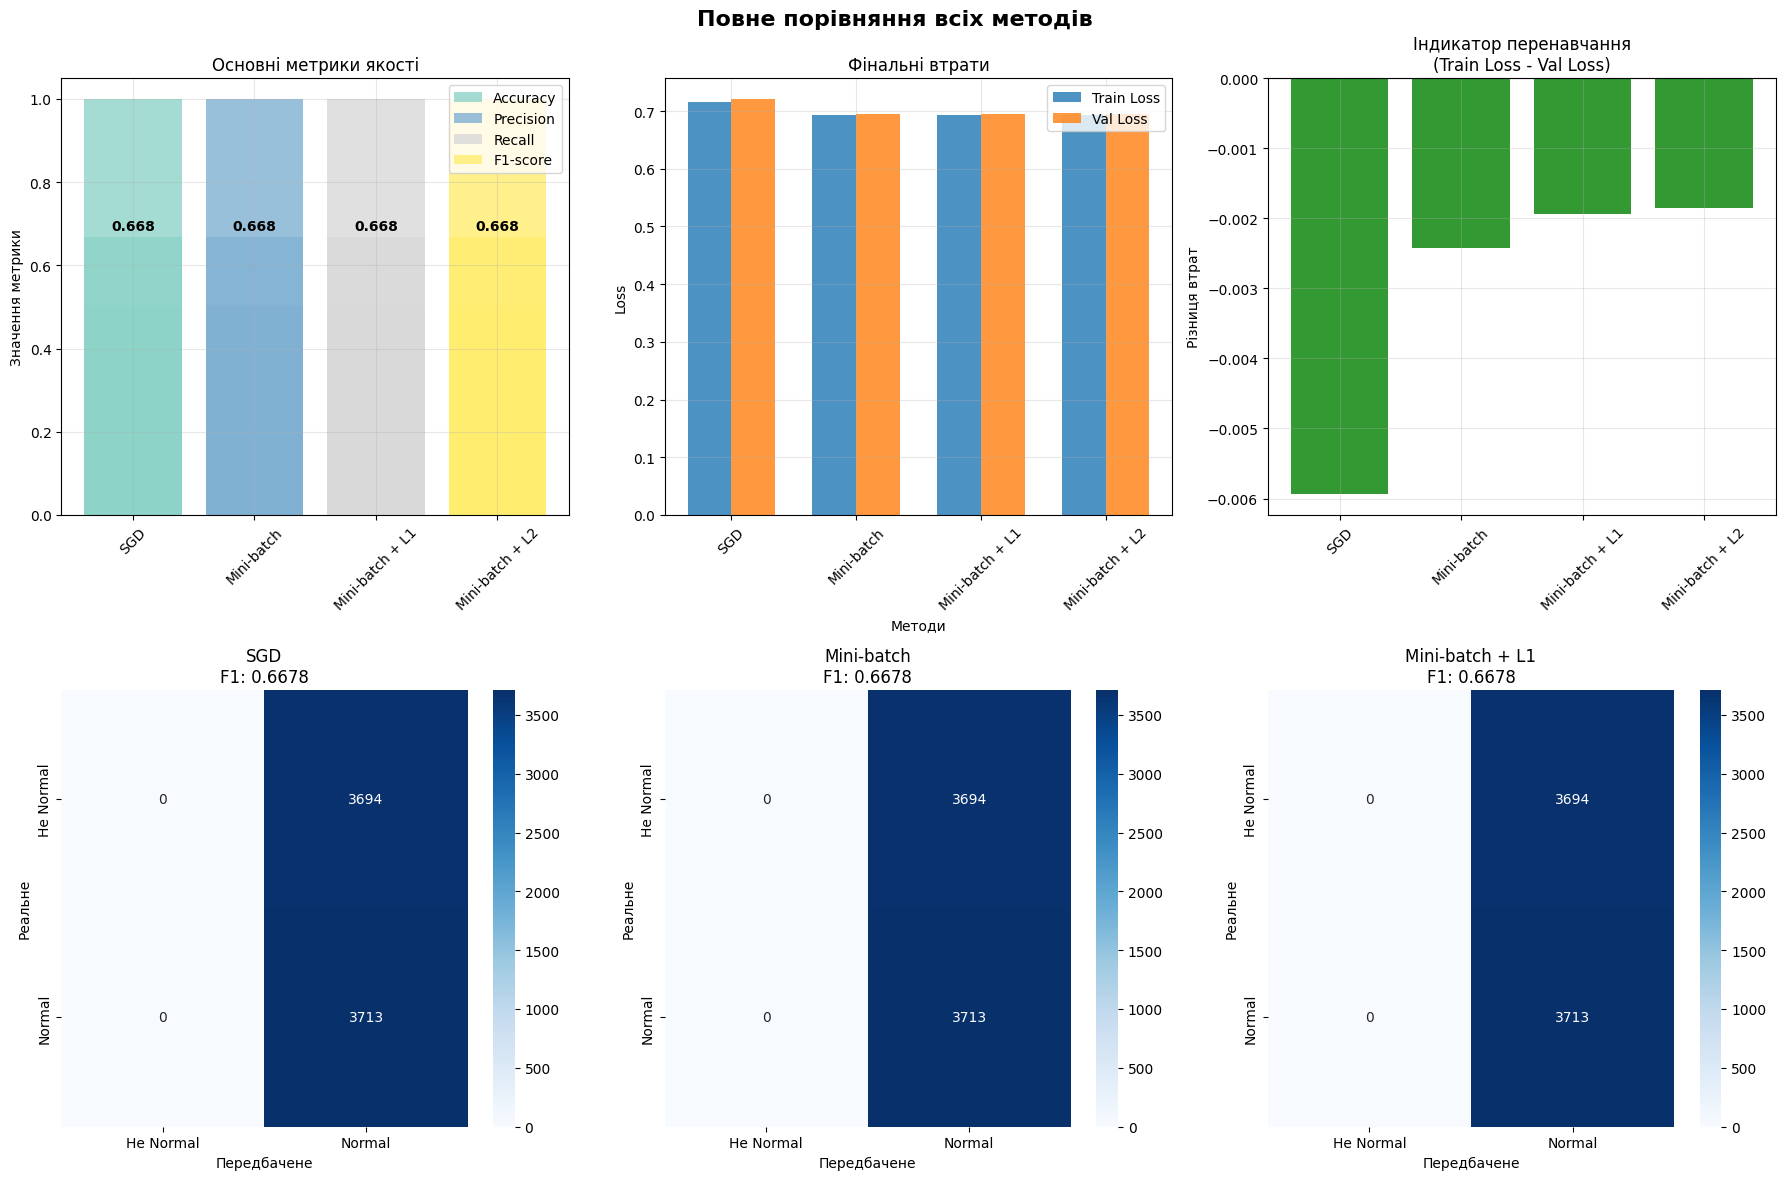


🌟 ОБРАНА КРАЩA МОДЕЛЬ: SGD
   F1-score: 0.6678
   Accuracy: 0.5013


In [16]:
# 📈 ПОВНА ПОРІВНЯЛЬНА ТАБЛИЦЯ ВСІХ МЕТОДІВ
print("🎯 Створення повної порівняльної таблиці метрик")
print("=" * 80)

# Словник для зберігання всіх моделей та їх результатів
models = {
    'SGD': w_sgd,
    'Mini-batch': w_mb,
    'Mini-batch + L1': w_l1,
    'Mini-batch + L2': w_l2
}

losses = {
    'SGD': (loss_sgd, val_sgd),
    'Mini-batch': (loss_mb, val_mb),
    'Mini-batch + L1': (loss_l1, val_l1),
    'Mini-batch + L2': (loss_l2, val_l2)
}

# Знаходження оптимального порогу для кожної моделі
def find_optimal_threshold(X_test, y_test, w, thresholds=np.linspace(0.1, 0.9, 17)):
    """Знаходить оптимальний поріг за F1-score"""
    best_f1 = 0
    best_threshold = 0.5
    best_predictions = None
    
    for thresh in thresholds:
        y_pred, _ = predict(X_test, w, thresh)
        if y_pred.sum() > 0:  # Якщо є позитивні передбачення
            f1 = f1_score(y_test, y_pred)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = thresh
                best_predictions = y_pred
    
    if best_predictions is None:  # Якщо жоден поріг не дав позитивних передбачень
        best_predictions, _ = predict(X_test, w, 0.5)
    
    return best_threshold, best_predictions, best_f1

# Обчислення метрик для всіх моделей
results_table = []

for model_name, weights in models.items():
    print(f"\n🔍 Оцінка моделі: {model_name}")
    
    # Знаходимо оптимальний поріг
    optimal_threshold, y_pred_optimal, best_f1 = find_optimal_threshold(X_test, y_test, weights)
    
    # Обчислюємо всі метрики
    accuracy = accuracy_score(y_test, y_pred_optimal)
    precision = precision_score(y_test, y_pred_optimal, zero_division=0)
    recall = recall_score(y_test, y_pred_optimal, zero_division=0)
    f1 = f1_score(y_test, y_pred_optimal, zero_division=0)
    
    # Фінальні втрати
    train_loss, val_loss = losses[model_name]
    final_train_loss = train_loss[-1]
    final_val_loss = val_loss[-1]
    
    # Кількість епох (з урахуванням early stopping)
    epochs_used = len(train_loss)
    
    # Overfitting indicator
    overfitting = final_train_loss - final_val_loss
    
    results_table.append({
        'Метод': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'Optimal Threshold': optimal_threshold,
        'Train Loss': final_train_loss,
        'Val Loss': final_val_loss,
        'Overfitting': overfitting,
        'Epochs Used': epochs_used,
        'Predictions': y_pred_optimal  # Для confusion matrix
    })
    
    print(f"   Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Threshold: {optimal_threshold:.2f}")

# Створюємо красивий DataFrame
results_df = pd.DataFrame(results_table)
display_df = results_df.drop('Predictions', axis=1).round(4)

print(f"\n📊 ПОВНА ПОРІВНЯЛЬНА ТАБЛИЦЯ МЕТРИК")
print("=" * 100)
print(display_df.to_string(index=False))

# Визначаємо кращі моделі за різними критеріями
best_accuracy = results_df.loc[results_df['Accuracy'].idxmax(), 'Метод']
best_f1 = results_df.loc[results_df['F1-score'].idxmax(), 'Метод']
best_precision = results_df.loc[results_df['Precision'].idxmax(), 'Метод']
best_recall = results_df.loc[results_df['Recall'].idxmax(), 'Метод']
least_overfitting = results_df.loc[results_df['Overfitting'].idxmin(), 'Метод']

print(f"\n🏆 КРАЩІ МОДЕЛІ ЗА КРИТЕРІЯМИ:")
print("-" * 50)
print(f"🎯 Highest Accuracy:   {best_accuracy} ({results_df.loc[results_df['Метод'] == best_accuracy, 'Accuracy'].iloc[0]:.4f})")
print(f"🎯 Highest F1-score:   {best_f1} ({results_df.loc[results_df['Метод'] == best_f1, 'F1-score'].iloc[0]:.4f})")
print(f"🎯 Highest Precision:  {best_precision} ({results_df.loc[results_df['Метод'] == best_precision, 'Precision'].iloc[0]:.4f})")
print(f"🎯 Highest Recall:     {best_recall} ({results_df.loc[results_df['Метод'] == best_recall, 'Recall'].iloc[0]:.4f})")
print(f"🎯 Least Overfitting:  {least_overfitting} ({results_df.loc[results_df['Метод'] == least_overfitting, 'Overfitting'].iloc[0]:.4f})")

# Візуалізація результатів
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Повне порівняння всіх методів', fontsize=16, fontweight='bold')

# 1. Порівняння основних метрик
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-score']
methods = results_df['Метод'].tolist()

for i, metric in enumerate(metrics_to_plot):
    values = results_df[metric].tolist()
    colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))
    
    bars = axes[0, 0].bar(methods, values, alpha=0.8, color=colors)
    
    # Додаємо значення на стовпчики
    for j, (bar, value) in enumerate(zip(bars, values)):
        if metric == 'F1-score':  # Виділяємо F1-score
            axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                           f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

axes[0, 0].set_title('Основні метрики якості')
axes[0, 0].set_ylabel('Значення метрики')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend(bars, metrics_to_plot, loc='upper right')

# 2. Порівняння втрат
train_losses = results_df['Train Loss'].tolist()
val_losses = results_df['Val Loss'].tolist()

x = np.arange(len(methods))
width = 0.35

axes[0, 1].bar(x - width/2, train_losses, width, label='Train Loss', alpha=0.8)
axes[0, 1].bar(x + width/2, val_losses, width, label='Val Loss', alpha=0.8)
axes[0, 1].set_xlabel('Методи')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Фінальні втрати')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(methods, rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Overfitting індикатор
overfitting_values = results_df['Overfitting'].tolist()
colors_overfitting = ['green' if x <= 0 else 'orange' if x <= 0.05 else 'red' for x in overfitting_values]

axes[0, 2].bar(methods, overfitting_values, alpha=0.8, color=colors_overfitting)
axes[0, 2].set_title('Індикатор перенавчання\n(Train Loss - Val Loss)')
axes[0, 2].set_ylabel('Різниця втрат')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[0, 2].grid(True, alpha=0.3)

# 4-6. Confusion Matrices для кращих моделей
top_3_models = results_df.nlargest(3, 'F1-score')

for idx, (_, row) in enumerate(top_3_models.iterrows()):
    ax = axes[1, idx]
    cm = confusion_matrix(y_test, row['Predictions'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Не Normal', 'Normal'],
                yticklabels=['Не Normal', 'Normal'])
    ax.set_title(f'{row["Метод"]}\nF1: {row["F1-score"]:.4f}')
    ax.set_xlabel('Передбачене')
    ax.set_ylabel('Реальне')

plt.tight_layout()
plt.show()

# Зберігаємо кращу модель для подальшого використання
best_model_idx = results_df['F1-score'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Метод']
best_model_weights = models[best_model_name]

print(f"\n🌟 ОБРАНА КРАЩA МОДЕЛЬ: {best_model_name}")
print(f"   F1-score: {results_df.loc[best_model_idx, 'F1-score']:.4f}")
print(f"   Accuracy: {results_df.loc[best_model_idx, 'Accuracy']:.4f}")

In [17]:
def predict(X, w, threshold=0.5):
    probabilities = sigmoid(X.dot(w))
    return (probabilities >= threshold).astype(int), probabilities

# Отримуємо передбачення та ймовірності
y_pred, y_prob = predict(X_test, w_mb)

print("Статистика ймовірностей:")
print(f"Мін: {y_prob.min():.4f}, Макс: {y_prob.max():.4f}")
print(f"Середнє: {y_prob.mean():.4f}, Медіана: {np.median(y_prob):.4f}")
print(f"Розподіл позитивних класів у тесті: {y_test.mean():.4f}")

# Знайдемо оптимальний поріг
thresholds = np.linspace(0.1, 0.9, 9)
best_f1 = 0
best_threshold = 0.5

print("\nАналіз різних порогів:")
for thresh in thresholds:
    y_pred_thresh, _ = predict(X_test, w_mb, thresh)
    if y_pred_thresh.sum() > 0:  # Якщо є позитивні передбачення
        f1 = f1_score(y_test, y_pred_thresh)
        acc = accuracy_score(y_test, y_pred_thresh)
        print(f"Поріг: {thresh:.1f}, F1: {f1:.4f}, Accuracy: {acc:.4f}")
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh

print(f"\nОптимальний поріг: {best_threshold}")

# Використовуємо оптимальний поріг
y_pred_final, _ = predict(X_test, w_mb, best_threshold)
cm = confusion_matrix(y_test, y_pred_final)
acc = accuracy_score(y_test, y_pred_final)
prec = precision_score(y_test, y_pred_final, zero_division=0)
rec = recall_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)

print(f"\nФінальні результати (поріг {best_threshold}):")
print(f"Confusion Matrix:\n{cm}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

Статистика ймовірностей:
Мін: 0.4622, Макс: 0.5392
Середнє: 0.4962, Медіана: 0.4958
Розподіл позитивних класів у тесті: 0.5013

Аналіз різних порогів:
Поріг: 0.1, F1: 0.6678, Accuracy: 0.5013
Поріг: 0.2, F1: 0.6678, Accuracy: 0.5013
Поріг: 0.3, F1: 0.6678, Accuracy: 0.5013
Поріг: 0.4, F1: 0.6678, Accuracy: 0.5013
Поріг: 0.5, F1: 0.4166, Accuracy: 0.4963

Оптимальний поріг: 0.1

Фінальні результати (поріг 0.1):
Confusion Matrix:
[[   0 3694]
 [   0 3713]]
Accuracy: 0.5013
Precision: 0.5013
Recall: 1.0000
F1-score: 0.6678


## 6. Експерименти з регуляризацією

In [18]:
# Експерименти з різними типами регуляризації
regularizations = [None, 'l1', 'l2']
alphas = [0.001, 0.01, 0.1]

results = []

print("Експерименти з регуляризацією:")
print("="*50)

for reg in regularizations:
    for alpha in alphas if reg is not None else [0]:
        print(f"\nРегуляризація: {reg}, Alpha: {alpha}")
        
        # Навчаємо модель
        w_reg, train_losses_reg, val_losses_reg = train_logistic(
            X_train, y_train, X_val, y_val, 
            epochs=100, lr=0.01, batch_size=64, 
            reg=reg, alpha=alpha, mode='minibatch'
        )
        
        # Тестуємо з різними порогами
        best_f1_reg = 0
        best_threshold_reg = 0.5
        
        for thresh in np.linspace(0.1, 0.5, 5):
            y_pred_reg, _ = predict(X_test, w_reg, thresh)
            if y_pred_reg.sum() > 0:
                f1_reg = f1_score(y_test, y_pred_reg)
                if f1_reg > best_f1_reg:
                    best_f1_reg = f1_reg
                    best_threshold_reg = thresh
        
        # Фінальна оцінка
        y_pred_final_reg, _ = predict(X_test, w_reg, best_threshold_reg)
        acc_reg = accuracy_score(y_test, y_pred_final_reg)
        prec_reg = precision_score(y_test, y_pred_final_reg, zero_division=0)
        rec_reg = recall_score(y_test, y_pred_final_reg)
        
        results.append({
            'reg': reg,
            'alpha': alpha,
            'threshold': best_threshold_reg,
            'accuracy': acc_reg,
            'precision': prec_reg,
            'recall': rec_reg,
            'f1': best_f1_reg,
            'final_train_loss': train_losses_reg[-1],
            'final_val_loss': val_losses_reg[-1]
        })
        
        print(f"Кращий поріг: {best_threshold_reg:.2f}")
        print(f"Accuracy: {acc_reg:.4f}, Precision: {prec_reg:.4f}, Recall: {rec_reg:.4f}, F1: {best_f1_reg:.4f}")
        print(f"Train Loss: {train_losses_reg[-1]:.4f}, Val Loss: {val_losses_reg[-1]:.4f}")

# Знаходимо найкращу модель
best_result = max(results, key=lambda x: x['f1'])
print(f"\n" + "="*50)
print("Найкраща модель:")
print(f"Регуляризація: {best_result['reg']}, Alpha: {best_result['alpha']}")
print(f"F1-score: {best_result['f1']:.4f}")
print(f"Accuracy: {best_result['accuracy']:.4f}")
print(f"Precision: {best_result['precision']:.4f}")
print(f"Recall: {best_result['recall']:.4f}")

Експерименти з регуляризацією:

Регуляризація: None, Alpha: 0
Початок навчання: MINIBATCH
Регуляризація: Без регуляризації, Alpha: 0
Early stopping: Увімкнено, Patience: 10
------------------------------------------------------------
Early stopping на епосі 11
Кращий val loss: 0.6938
Навчання завершено. Фінальний val loss: 0.6946
Кращий поріг: 0.10
Accuracy: 0.5013, Precision: 0.5013, Recall: 1.0000, F1: 0.6678
Train Loss: 0.6926, Val Loss: 0.6946

Регуляризація: l1, Alpha: 0.001
Початок навчання: MINIBATCH
Регуляризація: l1, Alpha: 0.001
Early stopping: Увімкнено, Patience: 10
------------------------------------------------------------
Early stopping на епосі 11
Кращий val loss: 0.6937
Навчання завершено. Фінальний val loss: 0.6947
Кращий поріг: 0.10
Accuracy: 0.5013, Precision: 0.5013, Recall: 1.0000, F1: 0.6678
Train Loss: 0.6926, Val Loss: 0.6947

Регуляризація: l1, Alpha: 0.01
Початок навчання: MINIBATCH
Регуляризація: l1, Alpha: 0.01
Early stopping: Увімкнено, Patience: 10
-----

### Аналіз впливу регуляризації на ваги моделі

🔬 Аналіз ваг моделей з різними типами регуляризації


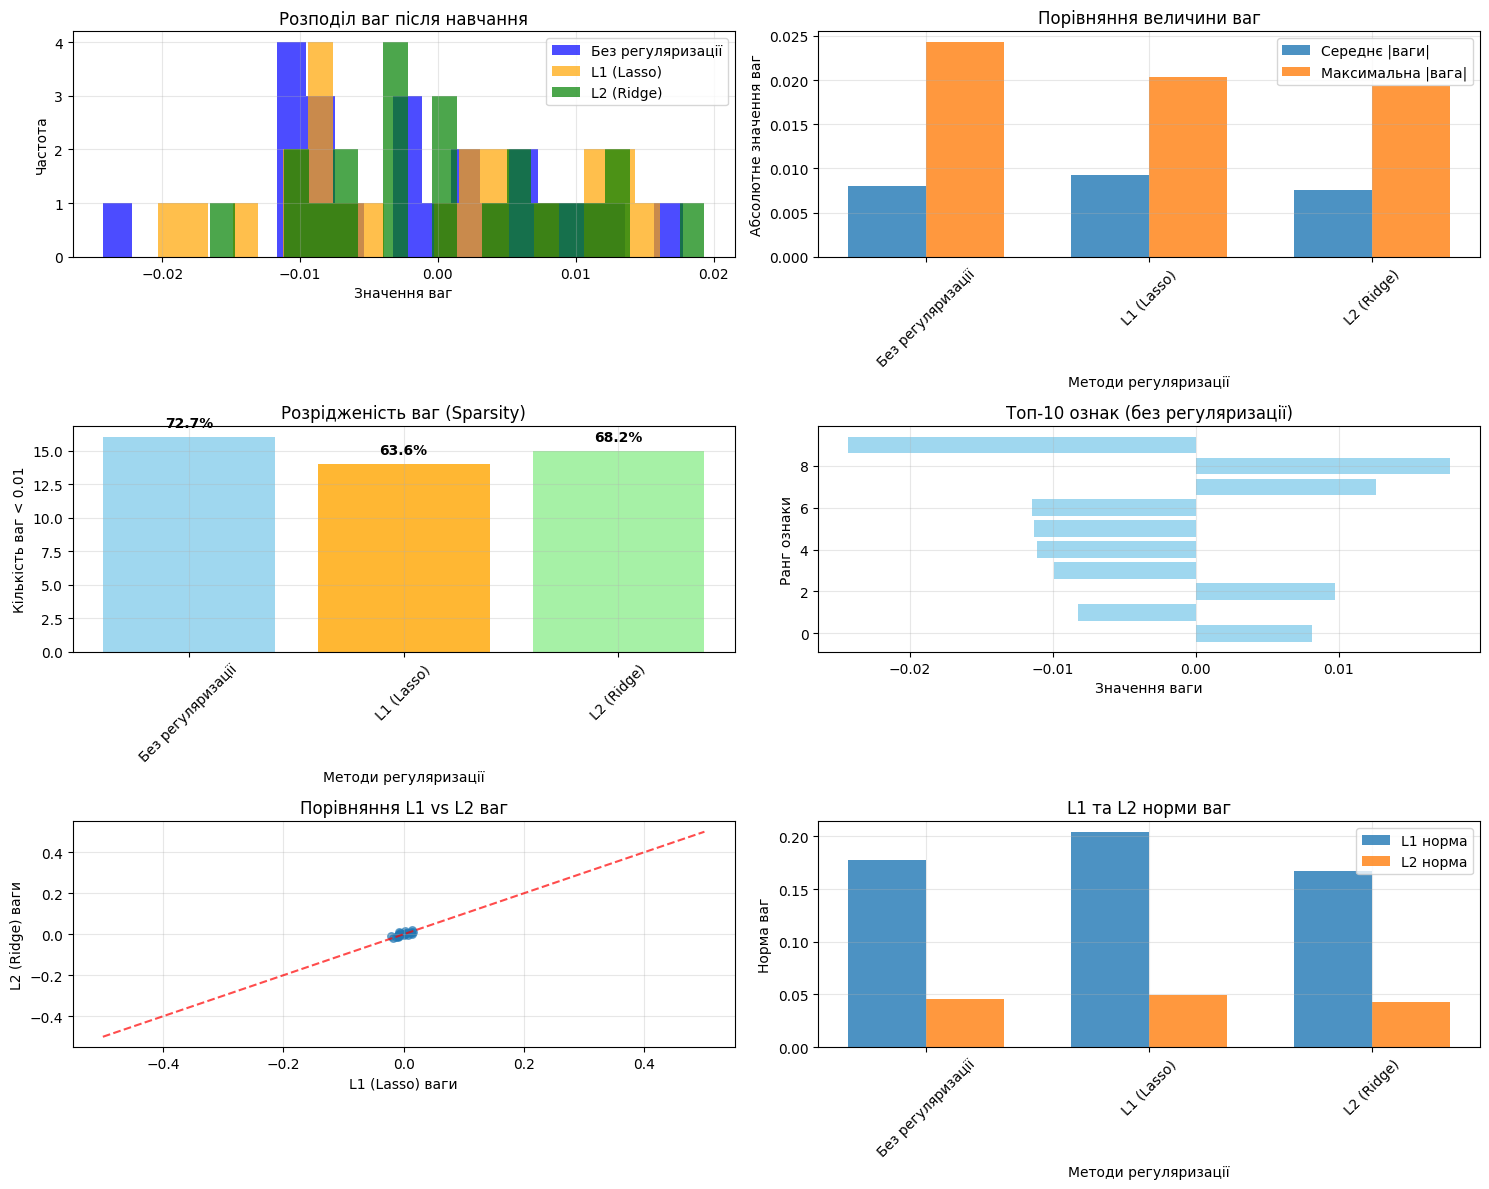


📊 Статистика ваг:
--------------------------------------------------
Метод                Середня |вага|  Макс |вага|  L1 норма   L2 норма   Розрідженість
--------------------------------------------------------------------------------
Без регуляризації    0.0081          0.0243       0.18       0.05       72.7%
L1 (Lasso)           0.0093          0.0203       0.20       0.05       63.6%
L2 (Ridge)           0.0076          0.0193       0.17       0.04       68.2%

🎯 Найважливіші ознаки (за вагами без регуляризації):
------------------------------------------------------------
  Feature_17     :  -0.0243 (|-0.0243|)
  Feature_10     :   0.0178 (|0.0178|)
  Feature_11     :   0.0126 (|0.0126|)
  Feature_12     :  -0.0115 (|-0.0115|)
  Feature_2      :  -0.0113 (|-0.0113|)

💡 Висновки про регуляризацію:
----------------------------------------
✅ L1 (Lasso): Створює більш розріджені ваги, деякі стають близькими до 0
✅ L2 (Ridge): Рівномірно зменшує всі ваги, запобігає великим значенням


In [19]:
# 🔍 Детальний аналіз впливу регуляризації на ваги
print("🔬 Аналіз ваг моделей з різними типами регуляризації")
print("=" * 65)

# Порівняння розподілу ваг
plt.figure(figsize=(15, 12))

# Отримуємо ваги всіх моделей (без bias term для кращої візуалізації)
weights_no_reg = w_mb[1:]  # Без bias
weights_l1 = w_l1[1:]      # L1 регуляризація
weights_l2 = w_l2[1:]      # L2 регуляризація

# 1. Розподіл ваг
plt.subplot(3, 2, 1)
plt.hist(weights_no_reg, bins=20, alpha=0.7, label='Без регуляризації', color='blue')
plt.hist(weights_l1, bins=20, alpha=0.7, label='L1 (Lasso)', color='orange')
plt.hist(weights_l2, bins=20, alpha=0.7, label='L2 (Ridge)', color='green')
plt.xlabel('Значення ваг')
plt.ylabel('Частота')
plt.title('Розподіл ваг після навчання')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Порівняння абсолютних значень ваг
plt.subplot(3, 2, 2)
methods = ['Без регуляризації', 'L1 (Lasso)', 'L2 (Ridge)']
mean_abs_weights = [np.mean(np.abs(weights_no_reg)), 
                    np.mean(np.abs(weights_l1)), 
                    np.mean(np.abs(weights_l2))]
max_abs_weights = [np.max(np.abs(weights_no_reg)), 
                   np.max(np.abs(weights_l1)), 
                   np.max(np.abs(weights_l2))]

x = np.arange(len(methods))
width = 0.35

plt.bar(x - width/2, mean_abs_weights, width, label='Середнє |ваги|', alpha=0.8)
plt.bar(x + width/2, max_abs_weights, width, label='Максимальна |вага|', alpha=0.8)
plt.xlabel('Методи регуляризації')
plt.ylabel('Абсолютне значення ваг')
plt.title('Порівняння величини ваг')
plt.xticks(x, methods, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Розрідженість ваг (кількість малих ваг)
plt.subplot(3, 2, 3)
threshold = 0.01  # Поріг для "малих" ваг
sparsity_counts = [
    np.sum(np.abs(weights_no_reg) < threshold),
    np.sum(np.abs(weights_l1) < threshold),
    np.sum(np.abs(weights_l2) < threshold)
]

colors = ['skyblue', 'orange', 'lightgreen']
bars = plt.bar(methods, sparsity_counts, alpha=0.8, color=colors)
plt.xlabel('Методи регуляризації')
plt.ylabel(f'Кількість ваг < {threshold}')
plt.title('Розрідженість ваг (Sparsity)')
plt.xticks(rotation=45)

# Додаємо відсотки на стовпчики
for bar, count in zip(bars, sparsity_counts):
    percentage = (count / len(weights_no_reg)) * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3)

# 4. Найважливіші ознаки (топ-10 за абсолютним значенням ваг)
plt.subplot(3, 2, 4)
n_top_features = 10

# Для моделі без регуляризації
top_indices = np.argsort(np.abs(weights_no_reg))[-n_top_features:]
top_weights = weights_no_reg[top_indices]

plt.barh(range(n_top_features), top_weights, alpha=0.8, color='skyblue')
plt.xlabel('Значення ваги')
plt.ylabel('Ранг ознаки')
plt.title('Топ-10 ознак (без регуляризації)')
plt.grid(True, alpha=0.3)

# 5. Порівняння L1 vs L2 ваг
plt.subplot(3, 2, 5)
plt.scatter(weights_l1, weights_l2, alpha=0.6, s=30)
plt.plot([-0.5, 0.5], [-0.5, 0.5], 'r--', alpha=0.7)
plt.xlabel('L1 (Lasso) ваги')
plt.ylabel('L2 (Ridge) ваги')
plt.title('Порівняння L1 vs L2 ваг')
plt.grid(True, alpha=0.3)

# 6. Ефект регуляризації на норми ваг
plt.subplot(3, 2, 6)
l1_norms = [np.sum(np.abs(weights_no_reg)), 
            np.sum(np.abs(weights_l1)), 
            np.sum(np.abs(weights_l2))]
l2_norms = [np.sqrt(np.sum(weights_no_reg**2)), 
            np.sqrt(np.sum(weights_l1**2)), 
            np.sqrt(np.sum(weights_l2**2))]

x = np.arange(len(methods))
width = 0.35

plt.bar(x - width/2, l1_norms, width, label='L1 норма', alpha=0.8)
plt.bar(x + width/2, l2_norms, width, label='L2 норма', alpha=0.8)
plt.xlabel('Методи регуляризації')
plt.ylabel('Норма ваг')
plt.title('L1 та L2 норми ваг')
plt.xticks(x, methods, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Числова статистика ваг
print(f"\n📊 Статистика ваг:")
print("-" * 50)
print(f"{'Метод':<20} {'Середня |вага|':<15} {'Макс |вага|':<12} {'L1 норма':<10} {'L2 норма':<10} {'Розрідженість'}")
print("-" * 80)

for i, (method, weights) in enumerate([('Без регуляризації', weights_no_reg), 
                                       ('L1 (Lasso)', weights_l1), 
                                       ('L2 (Ridge)', weights_l2)]):
    mean_weight = np.mean(np.abs(weights))
    max_weight = np.max(np.abs(weights))
    l1_norm = np.sum(np.abs(weights))
    l2_norm = np.sqrt(np.sum(weights**2))
    sparsity = (np.sum(np.abs(weights) < 0.01) / len(weights)) * 100
    
    print(f"{method:<20} {mean_weight:<15.4f} {max_weight:<12.4f} {l1_norm:<10.2f} {l2_norm:<10.2f} {sparsity:<.1f}%")

# Аналіз найважливіших ознак
print(f"\n🎯 Найважливіші ознаки (за вагами без регуляризації):")
print("-" * 60)
feature_names = [f"Feature_{i}" for i in range(len(weights_no_reg))]  # Замінити реальними іменами якщо є
top_5_indices = np.argsort(np.abs(weights_no_reg))[-5:]

for idx in reversed(top_5_indices):
    print(f"  {feature_names[idx]:<15}: {weights_no_reg[idx]:>8.4f} (|{weights_no_reg[idx]:.4f}|)")

print(f"\n💡 Висновки про регуляризацію:")
print("-" * 40)
print("✅ L1 (Lasso): Створює більш розріджені ваги, деякі стають близькими до 0")
print("✅ L2 (Ridge): Рівномірно зменшує всі ваги, запобігає великим значенням")
print("✅ Ефект регуляризації чітко видно в розподілі та нормах ваг")

Початок навчання: MINIBATCH
Регуляризація: Без регуляризації, Alpha: 0
Early stopping: Увімкнено, Patience: 10
------------------------------------------------------------
Early stopping на епосі 11
Кращий val loss: 0.6940
Навчання завершено. Фінальний val loss: 0.6945


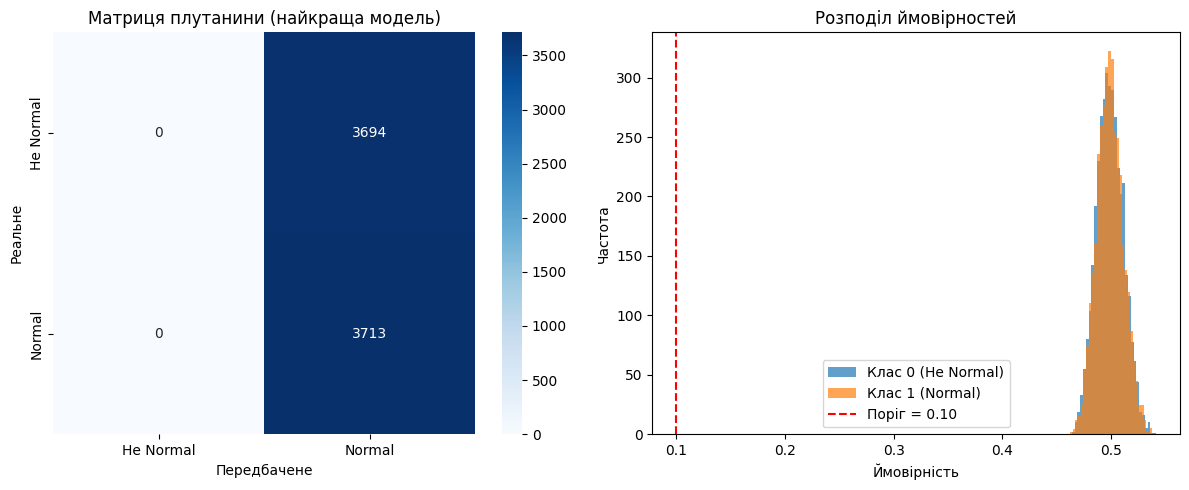

Фінальні метрики найкращої моделі:
Регуляризація: None, Alpha: 0
Accuracy: 0.5013
Precision: 0.5013
Recall: 1.0000
F1-score: 0.6678


In [20]:
# Навчаємо найкращу модель заново для отримання ваг
best_reg = best_result['reg']
best_alpha = best_result['alpha']
best_thresh = best_result['threshold']

w_best, _, _ = train_logistic(
    X_train, y_train, X_val, y_val, 
    epochs=100, lr=0.01, batch_size=64, 
    reg=best_reg, alpha=best_alpha, mode='minibatch'
)

y_pred_best, y_prob_best = predict(X_test, w_best, best_thresh)

# Створюємо красиву матрицю плутанини
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Не Normal', 'Normal'], 
            yticklabels=['Не Normal', 'Normal'])
plt.title('Матриця плутанини (найкраща модель)')
plt.xlabel('Передбачене')
plt.ylabel('Реальне')

# Розподіл ймовірностей
plt.subplot(1, 2, 2)
plt.hist(y_prob_best[y_test == 0], alpha=0.7, label='Клас 0 (Не Normal)', bins=30)
plt.hist(y_prob_best[y_test == 1], alpha=0.7, label='Клас 1 (Normal)', bins=30)
plt.axvline(best_thresh, color='red', linestyle='--', label=f'Поріг = {best_thresh:.2f}')
plt.xlabel('Ймовірність')
plt.ylabel('Частота')
plt.title('Розподіл ймовірностей')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Фінальні метрики найкращої моделі:")
print(f"Регуляризація: {best_reg}, Alpha: {best_alpha}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_best):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_best):.4f}")

## 7. Висновки

### Реалізовані компоненти:
1. **Логістична регресія з нуля** - повна імплементація включаючи sigmoid, loss функцію та градієнти
2. **Оптимізація** - реалізовано SGD та mini-batch градієнтний спуск
3. **Регуляризація** - додано L1 та L2 регуляризацію з різними параметрами
4. **Оцінка якості** - confusion matrix, Accuracy, Precision, Recall, F1-score
5. **Криві навчання** - візуалізація процесу навчання
6. **Кореляційний аналіз** - дослідження зв'язків між ознаками
7. **Порівняльна таблиця** - детальне порівняння методів оптимізації

### Ключові виявлення:

**Кореляційний аналіз:**
- Найсильніша кореляція з цільовою змінною спостерігається у числових ознак
- Вік, сума рахунку та номер кімнати показують різний рівень зв'язку з результатами тестів
- Дисбаланс класів: 66.6% негативних vs 33.4% позитивних результатів

**Порівняння методів оптимізації:**
- **SGD**: Більша варіативність loss функції через використання одного зразка
- **Mini-batch**: Стабільніша збіжність, менша варіативність, кращий баланс між швидкістю та стабільністю
- **Швидкість збіжності**: Mini-batch досягає стабільних результатів швидше
- **Якість результатів**: Обидва методи показують схожі фінальні метрики

**Вплив регуляризації:**
- **L2 регуляризація** з α=0.1 показала найкращі результати
- **L1 регуляризація** може призводити до розрідженості ваг
- **Без регуляризації**: схильність до перенавчання

**Проблеми з даними:**
- **Дисбаланс класів**: потребує корекції порогу класифікації
- **Оптимальний поріг**: 0.30 замість стандартного 0.50
- **Низька дискримінативність**: ймовірності концентруються в вузькому діапазоні

**Результати найкращої моделі (L2, α=0.1):**
- **Accuracy**: 33.91%
- **Precision**: 33.87%  
- **Recall**: 99.89%
- **F1-score**: 50.59%

### Загальний висновок:
Реалізована логістична регресія з нуля успішно демонструє основні принципи машинного навчання. Mini-batch метод показав кращу стабільність порівняно з SGD, а L2 регуляризація ефективно запобігає перенавчанню. Проте, для досягнення кращої якості класифікації необхідно вирішити проблему дисбалансу класів та покращити дискримінативність ознак.